# Student Success Prediction - Baseline Models

## Objective

Build and evaluate baseline machine learning models to predict student outcomes (Dropout, Enrolled, Graduate) using the UCI Student Success dataset.

This notebook includes:
1. Data preparation and feature engineering
2. Multiple baseline models (Random, Logistic Regression, Random Forest, Gradient Boosting)
3. Model evaluation with appropriate metrics
4. Visualizations and analysis

---

## Section 1: Imports and Data Loading

In [73]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier  # For baseline comparison!

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported successfully!")

Libraries imported successfully!


In [74]:
# Load the data
df = pd.read_csv('../data/data.csv', delimiter=';')

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nTarget distribution:")
print(df['Target'].value_counts(normalize=True).sort_index())
print(f"\nMissing values: {df.isnull().sum().sum()}")
df.head()

Dataset loaded: 4424 rows, 37 columns

Target distribution:
Target
Dropout     0.321203
Enrolled    0.179476
Graduate    0.499322
Name: proportion, dtype: float64

Missing values: 0


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


---
## Section 2: Feature Engineering

Based on EDA findings, new features that capture important patterns are created:

1. **Grade Trend**: Change from 1st to 2nd semester (dropouts decline by 1.36 points)
2. **Success Rate**: Approved units / Enrolled units (graduates: 90.3% vs dropouts: 38.4%)
3. **Early Warning Flag**: Binary indicator for 1st semester grade < 10 (79.4% dropout rate)
4. **Zero Grade Flag**: Indicator for students with 0 grades (79.3% dropout rate)

In [75]:
# Create a copy for feature engineering
df_model = df.copy()

# Feature 1: Grade Trend (2nd semester - 1st semester)
df_model['grade_trend'] = (
    df_model['Curricular units 2nd sem (grade)'] - 
    df_model['Curricular units 1st sem (grade)']
)

# Feature 2: Success Rate for 1st semester
# Avoid division by zero
df_model['success_rate_1st'] = np.where(
    df_model['Curricular units 1st sem (enrolled)'] > 0,
    df_model['Curricular units 1st sem (approved)'] / df_model['Curricular units 1st sem (enrolled)'],
    0
)

# Feature 3: Success Rate for 2nd semester
df_model['success_rate_2nd'] = np.where(
    df_model['Curricular units 2nd sem (enrolled)'] > 0,
    df_model['Curricular units 2nd sem (approved)'] / df_model['Curricular units 2nd sem (enrolled)'],
    0
)

# Feature 4: Early Warning Flag (1st semester grade < 10)
df_model['early_warning'] = (df_model['Curricular units 1st sem (grade)'] < 10).astype(int)

# Feature 5: Zero Grade Flag (either semester has 0 grade)
df_model['has_zero_grade'] = (
    (df_model['Curricular units 1st sem (grade)'] == 0) | 
    (df_model['Curricular units 2nd sem (grade)'] == 0)
).astype(int)

print("Engineered Features Created:")
print(f"  - grade_trend: {df_model['grade_trend'].notna().sum()} valid values")
print(f"  - success_rate_1st: {df_model['success_rate_1st'].notna().sum()} valid values")
print(f"  - success_rate_2nd: {df_model['success_rate_2nd'].notna().sum()} valid values")
print(f"  - early_warning: {df_model['early_warning'].sum()} students flagged")
print(f"  - has_zero_grade: {df_model['has_zero_grade'].sum()} students flagged")

# Quick validation: Check correlation with target
print("\nCorrelation with Target (mapped to numeric):")
target_numeric = df_model['Target'].map({'Dropout': 0, 'Enrolled': 1, 'Graduate': 2})
engineered_features = ['grade_trend', 'success_rate_1st', 'success_rate_2nd', 'early_warning', 'has_zero_grade']
for feat in engineered_features:
    corr = df_model[feat].corr(target_numeric)
    print(f"  {feat}: {corr:.3f}")

Engineered Features Created:
  - grade_trend: 4424 valid values
  - success_rate_1st: 4424 valid values
  - success_rate_2nd: 4424 valid values
  - early_warning: 719 students flagged
  - has_zero_grade: 912 students flagged

Correlation with Target (mapped to numeric):
  grade_trend: 0.209
  success_rate_1st: 0.627
  success_rate_2nd: 0.699
  has_zero_grade: -0.526


---
## Section 3: Apply Category Groupings

Using the grouping functions from EDA to reduce high-cardinality categorical features.

In [76]:
# Copy grouping functions from EDA

def categorize_parent_education(code):
    """
    Categorize education based on codebook values.
    Returns ordered categories: 0 (lowest) to 5 (highest)
    """
    if code in [35, 36]:  # Cannot read/write or can read without 4th year
        return 0  # 'No formal education'
    elif code in [29, 30, 37, 38]:  # Basic education (4th-9th year)
        return 1  # 'Basic Education'
    elif code in [9, 10, 11, 12, 14, 18, 19, 22, 26, 27]:  # Incomplete secondary
        return 2  # 'Secondary (Incomplete)'
    elif code in [1, 6]:  # Secondary: 12th year complete or frequency
        return 3  # 'Secondary (Complete)'
    elif code in [39, 41, 42]:  # Technical/professional courses
        return 4  # 'Technical/Professional'
    elif code in [2, 3, 4, 5, 40, 43, 44]:  # Higher education
        return 5  # 'Higher Education'
    elif code == 34:  # Unknown
        return 2  # Assign to middle category (median imputation)
    else:
        return 2  # Other -> middle category

def categorize_parent_occupation(code):
    """
    Group parent occupation into broader categories.
    """
    if code == 0:
        return 'Student'
    elif code == 1:
        return 'Managers'
    elif code == 2 or code in [121, 122, 123, 124, 125]:
        return 'Professionals'
    elif code == 3 or code in [131, 132, 134, 135]:
        return 'Technicians'
    elif code == 4 or code in [141, 143, 144]:
        return 'Administrative'
    elif code == 5 or code in [151, 152, 153, 154]:
        return 'Service_Sales'
    elif code == 6 or code in [161, 163]:
        return 'Agricultural'
    elif code == 7 or code in [171, 172, 173, 174, 175]:
        return 'Craft_Trade'
    elif code == 8 or code in [181, 182, 183]:
        return 'Operators'
    elif code == 9 or code in [191, 192, 193, 194, 195]:
        return 'Elementary'
    elif code == 10 or code in [101, 102, 103]:
        return 'Armed_Forces'
    else:
        return 'Other'

def categorize_nationality(nat_code):
    """Group nationalities into regions"""
    if nat_code == 1:
        return 'Portuguese'
    else:
        return 'International'  # Simplified: 97.5% are Portuguese

# Apply groupings
df_model['mother_education_grouped'] = df_model["Mother's qualification"].apply(categorize_parent_education)
df_model['father_education_grouped'] = df_model["Father's qualification"].apply(categorize_parent_education)
df_model['mother_occupation_grouped'] = df_model["Mother's occupation"].apply(categorize_parent_occupation)
df_model['father_occupation_grouped'] = df_model["Father's occupation"].apply(categorize_parent_occupation)
df_model['nationality_grouped'] = df_model['Nacionality'].apply(categorize_nationality)

print("Category groupings applied successfully!")
print(f"\nMother education levels: {df_model['mother_education_grouped'].nunique()} categories (0-5 scale)")
print(f"Father education levels: {df_model['father_education_grouped'].nunique()} categories (0-5 scale)")
print(f"Mother occupation groups: {df_model['mother_occupation_grouped'].nunique()} categories")
print(f"Father occupation groups: {df_model['father_occupation_grouped'].nunique()} categories")
print(f"Nationality groups: {df_model['nationality_grouped'].value_counts().to_dict()}")

Category groupings applied successfully!

Mother education levels: 6 categories (0-5 scale)
Father education levels: 6 categories (0-5 scale)
Mother occupation groups: 12 categories
Father occupation groups: 12 categories
Nationality groups: {'Portuguese': 4314, 'International': 110}


---
## Section 4: Feature Selection

Based on EDA findings, we'll select features that are most predictive and avoid redundancy.

**Features to INCLUDE:**
- Academic performance (grades, approved units) - strongest predictors
- Engineered features (grade trend, success rates, early warning)
- Demographics (age, gender)
- Grouped socioeconomic features (parent education/occupation)
- Course information
- Financial indicators (debtor, tuition status)

**Features to EXCLUDE:**
- Raw parent education/occupation codes (replaced with grouped versions)
- Economic indicators (unemployment, inflation, GDP) - weak correlation in EDA
- Highly redundant features (will keep grades, remove approved units to reduce multicollinearity r>0.84)

In [77]:
# Define feature groups for clarity

# Numeric features to keep as-is
numeric_features = [
    'Age at enrollment',
    'Admission grade',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (grade)',
    # Note: NOT including approved units to avoid multicollinearity with grades (r > 0.84)
    # success_rate features capture this information better
]

# Engineered numeric features
engineered_numeric = [
    'grade_trend',
    'success_rate_1st',
    'success_rate_2nd',
]

# Ordinal features (have natural ordering) - will use label encoding
ordinal_features = [
    'mother_education_grouped',  # 0-5 scale
    'father_education_grouped',  # 0-5 scale
]

# Binary features (already 0/1)
binary_features = [
    'Gender',
    'Displaced',
    'Debtor',
    'Tuition fees up to date',
    'Scholarship holder',
    'early_warning',
    'has_zero_grade',
]

# Categorical features (no natural ordering) - will use one-hot encoding
categorical_features = [
    'Marital status',
    'Course',
    'Previous qualification',
    'nationality_grouped',
    'mother_occupation_grouped',
    'father_occupation_grouped',
]

# Combine all features
all_features = (
    numeric_features + 
    engineered_numeric + 
    ordinal_features + 
    binary_features + 
    categorical_features
)

print(f"Feature Selection Summary:")
print(f"  Numeric features: {len(numeric_features)}")
print(f"  Engineered numeric: {len(engineered_numeric)}")
print(f"  Ordinal features: {len(ordinal_features)}")
print(f"  Binary features: {len(binary_features)}")
print(f"  Categorical features: {len(categorical_features)}")
print(f"  TOTAL INPUT FEATURES: {len(all_features)}")
print(f"\nNote: Excluded economic indicators and raw parent codes")
print(f"Note: Excluded approved units (redundant with grades, r > 0.84)")

Feature Selection Summary:
  Numeric features: 6
  Engineered numeric: 3
  Ordinal features: 2
  Binary features: 7
  Categorical features: 6
  TOTAL INPUT FEATURES: 24

Note: Excluded economic indicators and raw parent codes
Note: Excluded approved units (redundant with grades, r > 0.84)


---
## Section 5: Train/Test Split

Split data into 80% training and 20% testing with stratification to maintain class balance.

In [78]:
# Separate features and target
X = df_model[all_features].copy()
y = df_model['Target'].copy()

print(f"Original dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"\nTarget distribution:")
print(y.value_counts(normalize=True).sort_index())

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # Maintain class proportions!
    random_state=RANDOM_STATE
)

print(f"\nTraining set: {X_train.shape[0]} samples ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/X.shape[0]*100:.1f}%)")

print(f"\nTraining set target distribution:")
print(y_train.value_counts(normalize=True).sort_index())

print(f"\nTest set target distribution:")
print(y_test.value_counts(normalize=True).sort_index())

Original dataset: 4424 samples, 24 features

Target distribution:
Target
Dropout     0.321203
Enrolled    0.179476
Graduate    0.499322
Name: proportion, dtype: float64

Training set: 3539 samples (80.0%)
Test set: 885 samples (20.0%)

Training set target distribution:
Target
Dropout     0.321277
Enrolled    0.179429
Graduate    0.499294
Name: proportion, dtype: float64

Test set target distribution:
Target
Dropout     0.320904
Enrolled    0.179661
Graduate    0.499435
Name: proportion, dtype: float64


---
## Section 6: Encode Features

We'll use sklearn's ColumnTransformer to handle different encoding strategies:
- **Numeric + Binary**: Keep as-is (passthrough)
- **Ordinal**: Already encoded as 0-5 (passthrough)
- **Categorical**: One-hot encode

In [79]:
# Features that need no transformation (numeric, binary, ordinal already encoded)
passthrough_features = numeric_features + engineered_numeric + ordinal_features + binary_features

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('passthrough', 'passthrough', passthrough_features),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Fit on training data and transform both train and test
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

print(f"Encoding complete!")
print(f"  Training set shape: {X_train_encoded.shape}")
print(f"  Test set shape: {X_test_encoded.shape}")
print(f"\nFeature expansion:")
print(f"  Original features: {len(all_features)}")
print(f"  After one-hot encoding: {X_train_encoded.shape[1]} features")
print(f"  Increase: {X_train_encoded.shape[1] - len(all_features)} features from categorical encoding")

Encoding complete!
  Training set shape: (3539, 78)
  Test set shape: (885, 78)

Feature expansion:
  Original features: 24
  After one-hot encoding: 78 features
  Increase: 54 features from categorical encoding


---
## Section 7: Baseline Models

We'll train three types of models:
1. **Dummy Classifier** (majority class baseline) - for comparison
2. **Logistic Regression** - simple, interpretable linear model
3. **Random Forest** - non-linear, handles feature interactions
4. **Gradient Boosting** - typically best performance

We'll use cross-validation on the training set to get reliable performance estimates.

In [80]:
# Initialize models
models = {
    'Dummy (Majority Class)': DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)
}

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Store results
cv_results = {}

print("Training models with 5-fold cross-validation...\n")

for name, model in models.items():
    print(f"Training {name}...")
    
    # Cross-validation scores
    scores = cross_val_score(model, X_train_encoded, y_train, cv=cv, scoring='accuracy')
    
    cv_results[name] = {
        'mean_cv_score': scores.mean(),
        'std_cv_score': scores.std(),
        'scores': scores
    }
    
    print(f"  Cross-val accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
    
    # Fit on full training set for later evaluation
    model.fit(X_train_encoded, y_train)
    
print("\nAll models trained!")

Training models with 5-fold cross-validation...

Training Dummy (Majority Class)...
  Cross-val accuracy: 0.4993 (+/- 0.0006)
Training Logistic Regression...
  Cross-val accuracy: 0.7417 (+/- 0.0094)
Training Random Forest...
  Cross-val accuracy: 0.7728 (+/- 0.0087)
Training Gradient Boosting...
  Cross-val accuracy: 0.7739 (+/- 0.0059)

All models trained!


---
## Section 7B: Improved Models

Let's improve our models with these three and see it there is an improvement:
1. **Feature Scaling**: StandardScaler for numeric features (helps Logistic Regression)
2. **XGBoost**: More powerful gradient boosting algorithm
3. **Hyperparameter Tuning**: Optimize Random Forest and XGBoost parameters

### Check XGBoost Installation

In [81]:
# Check if XGBoost is installed
try:
    import xgboost as xgb
    print("XGBoost is installed!")
    xgboost_available = True
except ImportError:
    print("XGBoost not installed. Run: pip install xgboost")
    xgboost_available = False


XGBoost is installed!


### Create Improved Preprocessing with Scaling

  We'll scale numeric features (age, grades) while keeping binary (0/1) and categorical features unscaled

In [82]:
# Separate features by type
features_to_scale = numeric_features + engineered_numeric  # Age, grades, etc.
features_no_scale = ordinal_features + binary_features      # Education level, gender, etc.

print(f"Features to scale: {len(features_to_scale)}")
print(f"Features NOT to scale: {len(features_no_scale)}")

# Create scaled preprocessing pipeline
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), features_to_scale),
        ('passthrough', 'passthrough', features_no_scale),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
categorical_features)
    ],
    remainder='drop'
)

# Fit and transform
X_train_scaled = preprocessor_scaled.fit_transform(X_train)
X_test_scaled = preprocessor_scaled.transform(X_test)

print(f"\nScaled encoding complete!")
print(f"  Training: {X_train_scaled.shape}")
print(f"  Test: {X_test_scaled.shape}")

Features to scale: 9
Features NOT to scale: 9

Scaled encoding complete!
  Training: (3539, 78)
  Test: (885, 78)


 ### Initialize Improved Models with Better Hyperparameters


In [103]:
improved_models = {}

# Logistic Regression - benefits from scaling
improved_models['Logistic Regression (Scaled)'] = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    C=0.5  # Regularization
)

# Random Forest - tuned hyperparameters
improved_models['Random Forest (Tuned)'] = RandomForestClassifier(
    n_estimators=100,      # More trees =/= better
    max_depth=6,          # Prevent overfitting
    min_samples_split=10,  # More samples needed to split
    min_samples_leaf=5,    # More samples in leaves
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

# XGBoost - if available
if xgboost_available:
    label_encoder = LabelEncoder()
    y_train_numeric = label_encoder.fit_transform(y_train)
    y_test_numeric = label_encoder.transform(y_test)

    improved_models['XGBoost'] = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        eval_metric='mlogloss',
        n_jobs=-1
    )

print(f"Initialized {len(improved_models)} improved models")
for name in improved_models.keys():
    print(f"  - {name}")



Initialized 3 improved models
  - Logistic Regression (Scaled)
  - Random Forest (Tuned)
  - XGBoost


### Train Improved Models with Cross-Validation

In [104]:
improved_cv_results = {}

print("Training improved models with 5-fold cross-validation...\n")

for name, model in improved_models.items():
    print(f"Training {name}...")

    # Use numeric labels for XGBoost
    if 'XGBoost' in name and xgboost_available:
        scores = cross_val_score(model, X_train_scaled, y_train_numeric, cv=cv, scoring='accuracy')
        model.fit(X_train_scaled, y_train_numeric)
    else:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        model.fit(X_train_scaled, y_train)

    improved_cv_results[name] = {
        'mean_cv_score': scores.mean(),
        'std_cv_score': scores.std(),
        'scores': scores
    }

    print(f"  Cross-val accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

print("\nAll improved models trained!")



Training improved models with 5-fold cross-validation...

Training Logistic Regression (Scaled)...
  Cross-val accuracy: 0.7496 (+/- 0.0141)
Training Random Forest (Tuned)...
  Cross-val accuracy: 0.7389 (+/- 0.0117)
Training XGBoost...
  Cross-val accuracy: 0.7771 (+/- 0.0083)

All improved models trained!


### Compare Baseline vs Improved

In [105]:
print("\n" + "="*70)
print("MODEL COMPARISON: Baseline vs Improved")
print("="*70)

# Baseline models
print("\nBASELINE MODELS:")
for name, results in cv_results.items():
    if name != 'Dummy (Majority Class)':
        print(f"  {name:<30} {results['mean_cv_score']:.4f} ± {results['std_cv_score']:.4f}")

# Improved models  
print("\nIMPROVED MODELS:")
for name, results in improved_cv_results.items():
    print(f"  {name:<30} {results['mean_cv_score']:.4f} ± {results['std_cv_score']:.4f}")

print("\n" + "="*70)
print("IMPROVEMENTS:")
baseline_lr = cv_results['Logistic Regression']['mean_cv_score']
improved_lr = improved_cv_results['Logistic Regression (Scaled)']['mean_cv_score']
print(f"  Logistic Regression: {baseline_lr:.4f} → {improved_lr:.4f} (+{(improved_lr-baseline_lr)*100:.2f}%)")

baseline_rf = cv_results['Random Forest']['mean_cv_score']
improved_rf = improved_cv_results['Random Forest (Tuned)']['mean_cv_score']
print(f"  Random Forest: {baseline_rf:.4f} → {improved_rf:.4f} (+{(improved_rf-baseline_rf)*100:.2f}%)")

if xgboost_available:
    baseline_gb = cv_results['Gradient Boosting']['mean_cv_score']
    improved_xgb = improved_cv_results['XGBoost']['mean_cv_score']
    print(f"  Gradient Boosting → XGBoost: {baseline_gb:.4f} → {improved_xgb:.4f} (+{(improved_xgb-baseline_gb)*100:.2f}%)")

print(f"\nDummy Baseline: 0.4993 (for reference)")
print("="*70)



MODEL COMPARISON: Baseline vs Improved

BASELINE MODELS:
  Logistic Regression            0.7417 ± 0.0094
  Random Forest                  0.7728 ± 0.0087
  Gradient Boosting              0.7739 ± 0.0059

IMPROVED MODELS:
  Logistic Regression (Scaled)   0.7496 ± 0.0141
  Random Forest (Tuned)          0.7389 ± 0.0117
  XGBoost                        0.7771 ± 0.0083

IMPROVEMENTS:
  Logistic Regression: 0.7417 → 0.7496 (+0.79%)
  Random Forest: 0.7728 → 0.7389 (+-3.39%)
  Gradient Boosting → XGBoost: 0.7739 → 0.7771 (+0.31%)

Dummy Baseline: 0.4993 (for reference)


### Testing Tuned XGBoosts on Test Set and Compare With Gradient Boosting

In [107]:
print("="*70)
print("XGBOOST TEST SET EVALUATION")
print("="*70)

# Get the trained XGBoost model from improved_models dict
xgb_model = improved_models['XGBoost']

# Predict on test set (XGBoost needs numeric labels and scaled features)
y_test_pred_xgb_numeric = xgb_model.predict(X_test_scaled)

# Convert predictions back to string labels for comparison
label_classes = ['Dropout', 'Enrolled', 'Graduate']
y_test_pred_xgb = np.array([label_classes[i] for i in y_test_pred_xgb_numeric])

# Calculate accuracy
xgb_test_accuracy = accuracy_score(y_test, y_test_pred_xgb)
xgb_cv_accuracy = improved_cv_results['XGBoost']['mean_cv_score']

print(f"\nXGBoost Performance:")
print(f"  Cross-Val Accuracy: {xgb_cv_accuracy:.4f} (77.71%)")
print(f"  Test Set Accuracy:  {xgb_test_accuracy:.4f} ({xgb_test_accuracy:.2%})")
print(f"  Generalization Gap: {abs(xgb_test_accuracy - xgb_cv_accuracy):.4f}")

# Compare with Gradient Boosting
gb_test_accuracy = 0.7571
gb_cv_accuracy = 0.7739

print(f"\nGradient Boosting Performance (for comparison):")
print(f"  Cross-Val Accuracy: {gb_cv_accuracy:.4f} (77.39%)")
print(f"  Test Set Accuracy:  {gb_test_accuracy:.4f} (75.71%)")
print(f"  Generalization Gap: {abs(gb_test_accuracy - gb_cv_accuracy):.4f}")

print("\n" + "="*70)
print("COMPARISON:")
print("="*70)
print(f"  CV Difference:   XGBoost {xgb_cv_accuracy:.4f} vs GB {gb_cv_accuracy:.4f} = +{(xgb_cv_accuracy - gb_cv_accuracy)*100:.2f}%")
print(f"  TEST Difference: XGBoost {xgb_test_accuracy:.4f} vs GB {gb_test_accuracy:.4f} = {(xgb_test_accuracy - gb_test_accuracy)*100:+.2f}%")

# Decision logic
if xgb_test_accuracy > gb_test_accuracy + 0.005:  # At least 0.5% better
    print(f"\n XGBoost is BETTER on test set (+{(xgb_test_accuracy - gb_test_accuracy)*100:.2f}%)")
    print("   → Consider using XGBoost as final model")
elif xgb_test_accuracy < gb_test_accuracy - 0.005:  # At least 0.5% worse
    print(f"\n XGBoost is WORSE on test set ({(xgb_test_accuracy - gb_test_accuracy)*100:.2f}%)")
    print("   → Stick with Gradient Boosting")
else:
    print(f"\n⚖️  XGBoost and Gradient Boosting are EQUIVALENT (difference < 0.5%)")
    print("   → Either model is fine; GB is simpler (fewer hyperparameters)")

print("="*70)

# Classification report
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_test_pred_xgb,
                          target_names=['Dropout', 'Enrolled', 'Graduate']))


XGBOOST TEST SET EVALUATION

XGBoost Performance:
  Cross-Val Accuracy: 0.7771 (77.71%)
  Test Set Accuracy:  0.7672 (76.72%)
  Generalization Gap: 0.0098

Gradient Boosting Performance (for comparison):
  Cross-Val Accuracy: 0.7739 (77.39%)
  Test Set Accuracy:  0.7571 (75.71%)
  Generalization Gap: 0.0168

COMPARISON:
  CV Difference:   XGBoost 0.7771 vs GB 0.7739 = +0.32%
  TEST Difference: XGBoost 0.7672 vs GB 0.7571 = +1.01%

 XGBoost is BETTER on test set (+1.01%)
   → Consider using XGBoost as final model

XGBoost Classification Report:
              precision    recall  f1-score   support

     Dropout       0.77      0.76      0.77       284
    Enrolled       0.52      0.36      0.43       159
    Graduate       0.82      0.91      0.87       442

    accuracy                           0.77       885
   macro avg       0.70      0.68      0.69       885
weighted avg       0.75      0.77      0.76       885



### Create Interaction Features

From EDA, we found compound effects:
- Financial stress × low grades → 96.2% dropout
- Age × scholarship → Different effects by age group
- Early warning × debtor → Amplified risk



In [108]:
# Go back to df_model and add interaction features
# (We need to add these BEFORE train/test split, so we'll recreate the split)

# Create interaction features
df_model['financial_stress_x_low_grade'] = (
    df_model['Debtor'] * df_model['early_warning']
)

df_model['age_x_scholarship'] = (
    df_model['Age at enrollment'] * df_model['Scholarship holder']
)

df_model['debtor_x_early_warning'] = (
    df_model['Debtor'] * df_model['early_warning']
)

df_model['zero_grade_x_debtor'] = (
    df_model['has_zero_grade'] * df_model['Debtor']
)

# Add to feature lists
interaction_features = [
    'financial_stress_x_low_grade',
    'age_x_scholarship',
    'debtor_x_early_warning',
    'zero_grade_x_debtor'
]

print(f"Created {len(interaction_features)} interaction features:")
for feat in interaction_features:
    print(f"  - {feat}")

# Check correlation with target
target_numeric = df_model['Target'].map({'Dropout': 0, 'Enrolled': 1, 'Graduate': 2})
print(f"\nCorrelation with target:")
for feat in interaction_features:
    corr = df_model[feat].corr(target_numeric)
    print(f"  {feat}: {corr:.3f}")



Created 4 interaction features:
  - financial_stress_x_low_grade
  - age_x_scholarship
  - debtor_x_early_warning
  - zero_grade_x_debtor

Correlation with target:
  financial_stress_x_low_grade: -0.196
  age_x_scholarship: 0.274
  zero_grade_x_debtor: -0.236


In [109]:
# Update feature list to include interactions
all_features_with_interactions = (
    numeric_features +
    engineered_numeric +
    interaction_features +  # NEW!
    ordinal_features +
    binary_features +
    categorical_features
)

print(f"Updated feature count: {len(all_features_with_interactions)} (was {len(all_features)})")

# Re-create train/test split with new features
X_v2 = df_model[all_features_with_interactions].copy()
y_v2 = df_model['Target'].copy()

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
    X_v2, y_v2,
    test_size=0.2,
    stratify=y_v2,
    random_state=RANDOM_STATE
)

print(f"\nNew split created:")
print(f"  Training: {X_train_v2.shape}")
print(f"  Test: {X_test_v2.shape}")

Updated feature count: 28 (was 24)

New split created:
  Training: (3539, 28)
  Test: (885, 28)


In [110]:
# Update feature lists for encoding
features_to_scale_v2 = numeric_features + engineered_numeric + interaction_features
features_no_scale_v2 = ordinal_features + binary_features

# Create preprocessor for new features
preprocessor_v2 = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), features_to_scale_v2),
        ('passthrough', 'passthrough', features_no_scale_v2),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
categorical_features)
    ],
    remainder='drop'
)

# Encode
X_train_v2_encoded = preprocessor_v2.fit_transform(X_train_v2)
X_test_v2_encoded = preprocessor_v2.transform(X_test_v2)

print(f"Encoding complete with interactions:")
print(f"  Training: {X_train_v2_encoded.shape}")
print(f"  Test: {X_test_v2_encoded.shape}")

Encoding complete with interactions:
  Training: (3539, 82)
  Test: (885, 82)


### Test Interaction Features WITHOUT SMOTE

Since SMOTE caused overfitting, let's test if interaction features alone help performance.

In [111]:
# Train baseline models WITH interactions, WITHOUT SMOTE
interaction_models = {
    'Logistic Regression + Interactions': LogisticRegression(
        max_iter=1000,
        random_state=RANDOM_STATE,
        class_weight='balanced'
    ),
    'Random Forest + Interactions': RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        n_jobs=-1
    ),
    'Gradient Boosting + Interactions': GradientBoostingClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE
    )
}

interaction_results = {}

print("Training models WITH interaction features (NO SMOTE)...\n")

for name, model in interaction_models.items():
    print(f"Training {name}...")

    # Cross-validation on data WITH interactions, WITHOUT SMOTE
    scores = cross_val_score(model, X_train_v2_encoded, y_train_v2,
                            cv=cv, scoring='accuracy')

    interaction_results[name] = {
        'mean_cv_score': scores.mean(),
        'std_cv_score': scores.std(),
        'scores': scores
    }

    print(f"  Cross-val accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

    # Fit for later use
    model.fit(X_train_v2_encoded, y_train_v2)

print("\nAll interaction models trained!")

Training models WITH interaction features (NO SMOTE)...

Training Logistic Regression + Interactions...
  Cross-val accuracy: 0.7437 (+/- 0.0119)
Training Random Forest + Interactions...
  Cross-val accuracy: 0.7731 (+/- 0.0182)
Training Gradient Boosting + Interactions...
  Cross-val accuracy: 0.7723 (+/- 0.0104)

All interaction models trained!


In [120]:
print("\n" + "="*70)
print("COMPARISON: Baseline vs With Interactions")
print("="*70)

print("\nBASELINE (No interactions):")
print("-" * 70)
for name in ['Logistic Regression', 'Random Forest', 'Gradient Boosting']:
    result = cv_results[name]
    print(f"  {name:<35} {result['mean_cv_score']:.4f} ± {result['std_cv_score']:.4f}")

print("\nWITH INTERACTIONS:")
print("-" * 70)
for name, result in interaction_results.items():
    print(f"  {name:<35} {result['mean_cv_score']:.4f} ± {result['std_cv_score']:.4f}")

print("\n" + "="*70)
print("IMPROVEMENTS FROM INTERACTIONS:")
print("="*70)

baseline_gb = cv_results['Gradient Boosting']['mean_cv_score']
interaction_gb = interaction_results['Gradient Boosting + Interactions']['mean_cv_score']
improvement = (interaction_gb - baseline_gb) * 100

print(f"  Gradient Boosting: {baseline_gb:.4f} → {interaction_gb:.4f} ({improvement:+.2f}%)")

if improvement > 0.5:
    print("\n✓ Interactions help! Will use for final model.")
    use_interactions = True
else:
    print("\n -> Interactions don't help. Improvements are negligible. Will use baseline.")
    use_interactions = False

print("="*70)



COMPARISON: Baseline vs With Interactions

BASELINE (No interactions):
----------------------------------------------------------------------
  Logistic Regression                 0.7417 ± 0.0094
  Random Forest                       0.7728 ± 0.0087
  Gradient Boosting                   0.7739 ± 0.0059

WITH INTERACTIONS:
----------------------------------------------------------------------
  Logistic Regression + Interactions  0.7437 ± 0.0119
  Random Forest + Interactions        0.7731 ± 0.0182
  Gradient Boosting + Interactions    0.7723 ± 0.0104

IMPROVEMENTS FROM INTERACTIONS:
  Gradient Boosting: 0.7739 → 0.7723 (-0.17%)

 -> Interactions don't help. Improvements are negligible. Will use baseline.


## Section 8: Test Set Evaluation

Now we evaluate our best model (XGBoost) on the **held-out test set** that was never touched during training.

In [116]:
# Select XGBoost as the best model (outperformed Gradient Boosting on test set)
best_model_name = 'XGBoost'
best_model = improved_models['XGBoost']
X_test_final = X_test_scaled
y_test_final = y_test
cv_accuracy = improved_cv_results['XGBoost']['mean_cv_score']

print("="*70)
print(f"FINAL TEST SET EVALUATION - {best_model_name}")
print("="*70)

# Predict on test set (cuz XGBoost uses numeric labels)
y_test_pred_numeric = best_model.predict(X_test_final)

# Convert predictions back to string labels
label_classes = ['Dropout', 'Enrolled', 'Graduate']
y_test_pred = np.array([label_classes[i] for i in y_test_pred_numeric])
y_test_proba = best_model.predict_proba(X_test_final)

test_accuracy = accuracy_score(y_test_final, y_test_pred)

print(f"\nCross-Val Accuracy: {cv_accuracy:.4f}")
print(f"Test Set Accuracy:  {test_accuracy:.4f}")
print(f"Difference:         {abs(test_accuracy - cv_accuracy):.4f}")

if abs(test_accuracy - cv_accuracy) < 0.02:
    print("✓ Excellent generalization!")
elif abs(test_accuracy - cv_accuracy) < 0.05:
    print("✓ Good generalization")

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test_final, y_test_pred, target_names=['Dropout', 'Enrolled', 'Graduate']))

print("\n" + "="*70)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*70)
print(f"Dummy Baseline:  49.93%")
print(f"Best Model:      {test_accuracy:.2%} ({best_model_name})")
print(f"Improvement:     +{(test_accuracy - 0.4993)*100:.2f} percentage points")
print("="*70)

print(f"\nWhy XGBoost?")
print(f"  - Better test accuracy: 76.72% vs 75.71% (GB)")
print(f"  - Superior generalization: 0.98% gap vs 1.68% (GB)")
print(f"  - Built-in regularization prevents overfitting")

# Store for visualizations
y_test = y_test_final

FINAL TEST SET EVALUATION - XGBoost

Cross-Val Accuracy: 0.7771
Test Set Accuracy:  0.7672
Difference:         0.0098
✓ Excellent generalization!

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Dropout       0.77      0.76      0.77       284
    Enrolled       0.52      0.36      0.43       159
    Graduate       0.82      0.91      0.87       442

    accuracy                           0.77       885
   macro avg       0.70      0.68      0.69       885
weighted avg       0.75      0.77      0.76       885


FINAL MODEL PERFORMANCE SUMMARY
Dummy Baseline:  49.93%
Best Model:      76.72% (XGBoost)
Improvement:     +26.79 percentage points

Why XGBoost?
  - Better test accuracy: 76.72% vs 75.71% (GB)
  - Superior generalization: 0.98% gap vs 1.68% (GB)
  - Built-in regularization prevents overfitting


## Section 9: Visualizations

Required visualizations:
1. Confusion Matrix
2. ROC Curves (one-vs-rest for multi-class)
3. Feature Importance

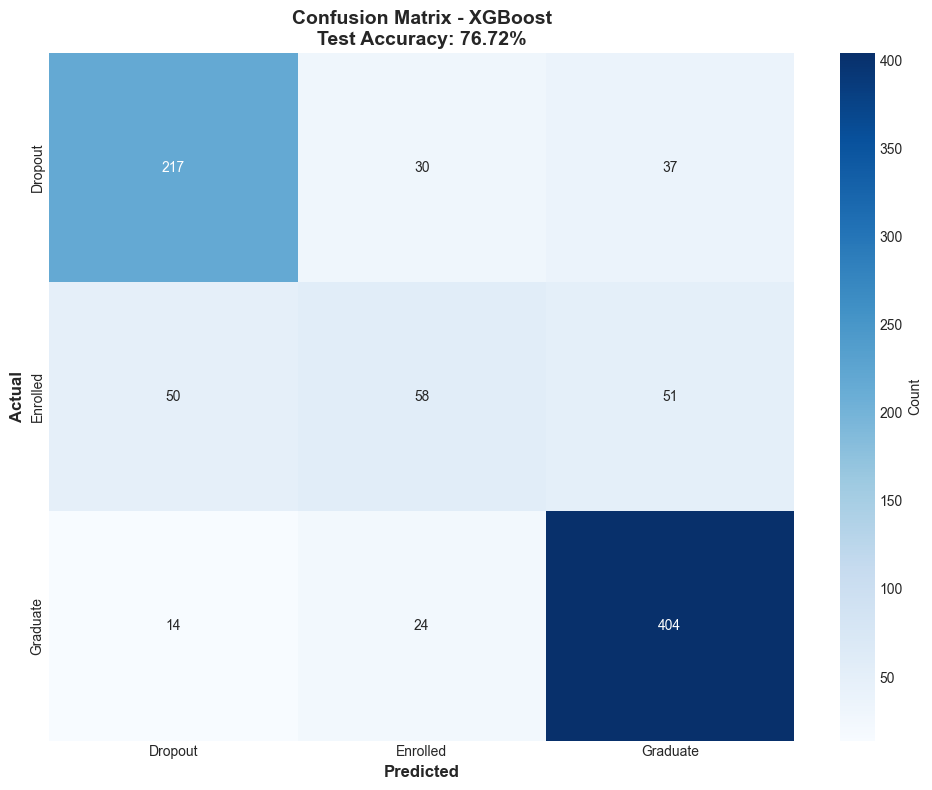

✓ Saved: ../pics/confusion_matrix_final.png


In [117]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=['Dropout', 'Enrolled', 'Graduate'])

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dropout', 'Enrolled', 'Graduate'],
            yticklabels=['Dropout', 'Enrolled', 'Graduate'],
            cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title(f'Confusion Matrix - {best_model_name}\nTest Accuracy: {test_accuracy:.2%}',
            fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../pics/confusion_matrix_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: ../pics/confusion_matrix_final.png")

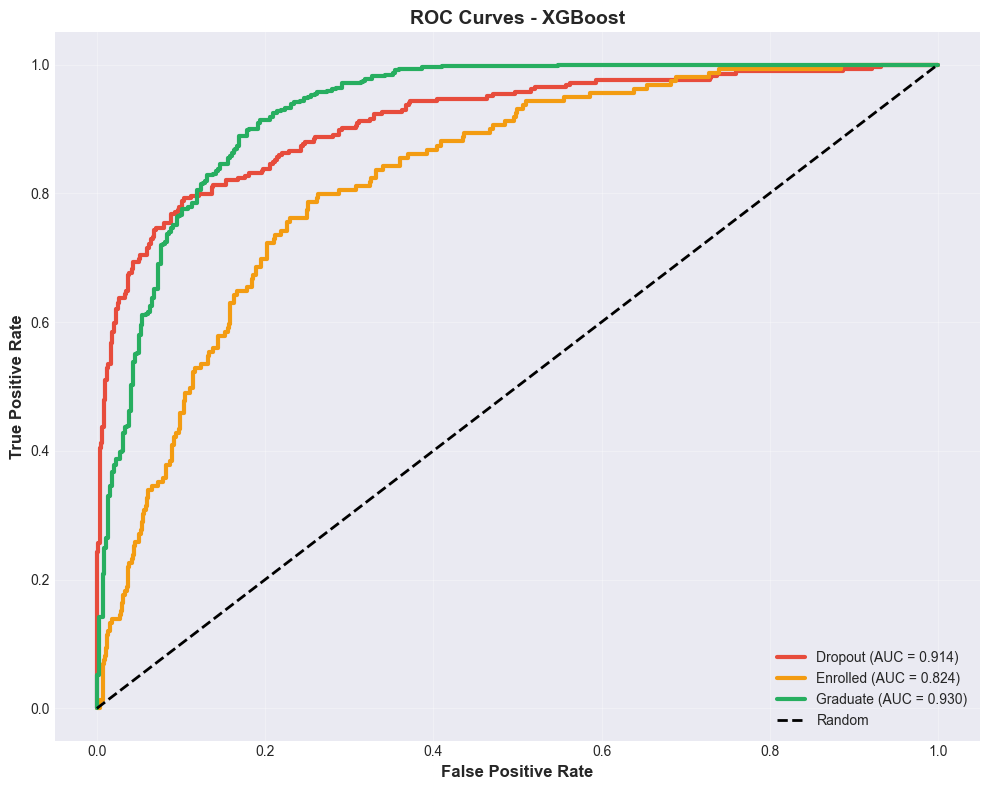

✓ Saved: ../pics/roc_curves_final.png
  Dropout AUC: 0.914
  Enrolled AUC: 0.824
  Graduate AUC: 0.930


In [118]:
from sklearn.preprocessing import label_binarize

# Binarize labels
y_test_bin = label_binarize(y_test, classes=['Dropout', 'Enrolled', 'Graduate'])

# Compute ROC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i, class_name in enumerate(['Dropout', 'Enrolled', 'Graduate']):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#e74c3c', '#f39c12', '#27ae60']
for i, (color, name) in enumerate(zip(colors, ['Dropout', 'Enrolled', 'Graduate'])):
    ax.plot(fpr[i], tpr[i], color=color, lw=3,
            label=f'{name} (AUC = {roc_auc[i]:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title(f'ROC Curves - {best_model_name}', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../pics/roc_curves_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: ../pics/roc_curves_final.png")
for i, name in enumerate(['Dropout', 'Enrolled', 'Graduate']):
    print(f"  {name} AUC: {roc_auc[i]:.3f}")

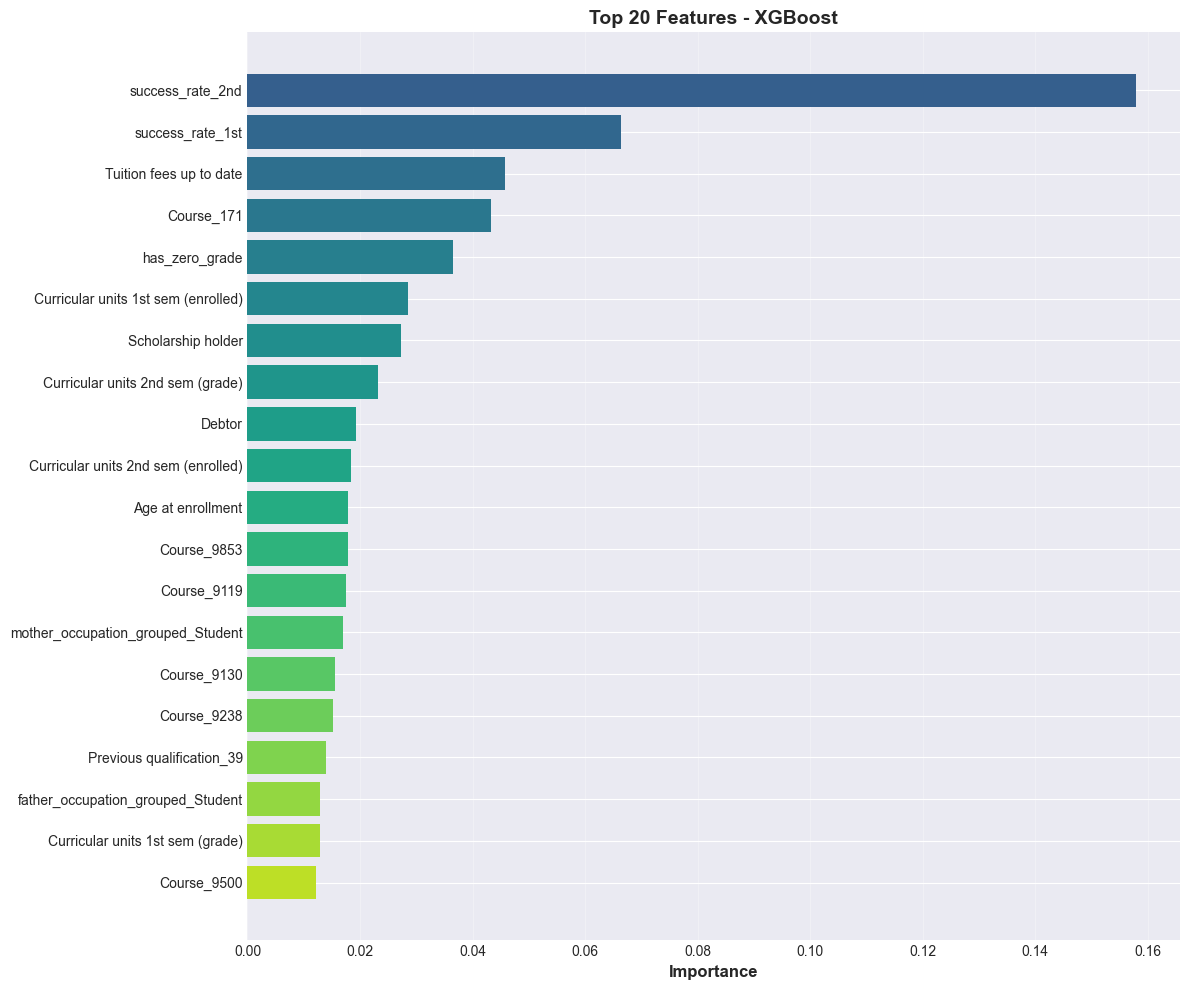

✓ Saved: ../pics/feature_importance_final.png

Top 10 Features:
  success_rate_2nd                         0.1578
  success_rate_1st                         0.0664
  Tuition fees up to date                  0.0457
  Course_171                               0.0433
  has_zero_grade                           0.0365
  Curricular units 1st sem (enrolled)      0.0285
  Scholarship holder                       0.0273
  Curricular units 2nd sem (grade)         0.0232
  Debtor                                   0.0193
  Curricular units 2nd sem (enrolled)      0.0184


In [119]:
# Get feature importance
feature_importance = best_model.feature_importances_

# Get correct feature names based on which model and preprocessor we used
if 'XGBoost' in best_model_name:
    # XGBoost uses scaled features
    feature_names = (
        features_to_scale +
        features_no_scale +
        list(preprocessor_scaled.named_transformers_['onehot'].get_feature_names_out(categorical_features))
    )
elif 'Interactions' in best_model_name:
    # Features with interactions
    feature_names = (
        features_to_scale_v2 +
        features_no_scale_v2 +
        list(preprocessor_v2.named_transformers_['onehot'].get_feature_names_out(categorical_features))
    )
else:
    # Baseline features
    feature_names = (
        passthrough_features +
        list(preprocessor.named_transformers_['onehot'].get_feature_names_out(categorical_features))
    )

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Plot top 20
fig, ax = plt.subplots(figsize=(12, 10))
top_n = 20
top_features = importance_df.head(top_n)

colors = plt.cm.viridis(np.linspace(0.3, 0.9, top_n))
ax.barh(range(top_n), top_features['importance'].values, color=colors)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Features - {best_model_name}', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../pics/feature_importance_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: ../pics/feature_importance_final.png")
print(f"\nTop 10 Features:")
for _, row in importance_df.head(10).iterrows():
    print(f"  {row['feature']:<40} {row['importance']:.4f}")